**1. Inicialización**

El primer paso será importar las bibliotecas necesarias e incializar variables

**1a. Inicialización - Importar bibliotecas**

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
from skimage.segmentation import clear_border
import pytesseract
import imutils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,808 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

**1b. Inicialización - Variables**

*widePlatePx* y *tallPlatePx* son las dimensiones en pixeles de la matricula, que se va a usar como kernel para distintas operaciones

*minAR* y *maxAR* son las cotas de las proporciones de las matriculas (es decir el valor de ancho matricula / alto matricula), que van a ser utilizados para encontrar objetos con esas características en la imagen.

*keep* es la cantidad de objetos que voy a testear en la imagen a ver si son matriculas

*psm* es un parámetro de Tesseract's, que el valor 7 indica : “treat the image as a single text line”

In [2]:
widePlatePx=13
tallPlatePx=5
minAR=2
maxAR=6
keep=5
psm=7

# configuro el tamaño de las impresiones en pantalla
plt.rcParams["figure.figsize"] = (20,15)

**2. Input data - Cargo Imágenes**

In [3]:
# Clonamos el repositorio que contiene las imágenes con las que vamos a trabajar.

! git clone https://github.com/fdetta/plate_ocr_test.git

Cloning into 'plate_ocr_test'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 27 (delta 5), reused 21 (delta 3), pack-reused 0
Unpacking objects: 100% (27/27), done.


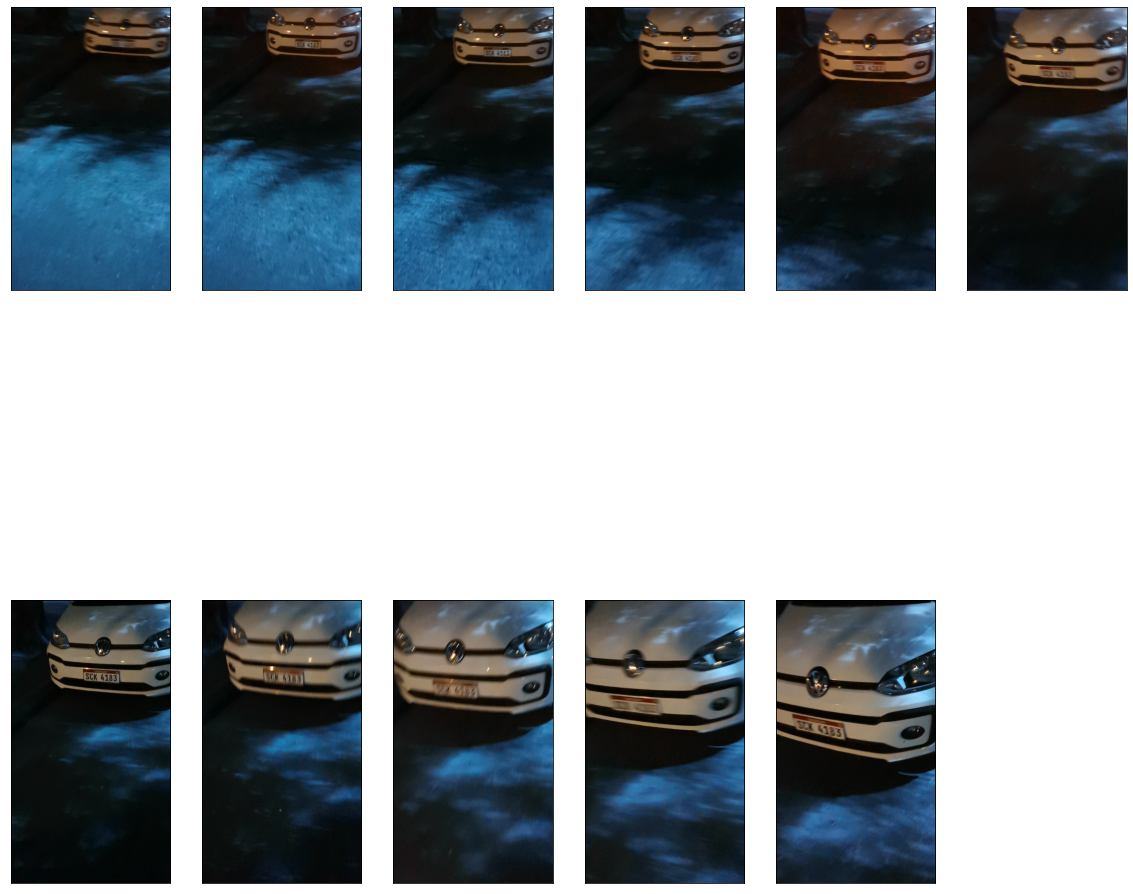

In [4]:
## código nuevo ##
# para pasar a fotos un video
import cv2
cap = cv2.VideoCapture('plate_ocr_test/Ex/video.mp4')
video_images = 'plate_ocr_test/'
if not cap.isOpened():
  exit(0)
#imagenes cada 10 frames
frameFrequency=10

total_frame = 0
id = 0
while True:
  ret, frame = cap.read()
  if ret is False:
    break
  total_frame += 1
  if total_frame%frameFrequency == 0:
    id += 1
    image_name = video_images + str(id) +'.jpg'
    rotated = imutils.rotate_bound(frame, 90)
    cv2.imwrite(image_name, rotated)
        
cap.release()

fig = plt.figure(figsize=(20,20))
for i in range(11):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[])
    image_name = video_images + str(i+1) +'.jpg'
    image = cv2.imread(image_name)
    ax.imshow(image)

## código nuevo ##

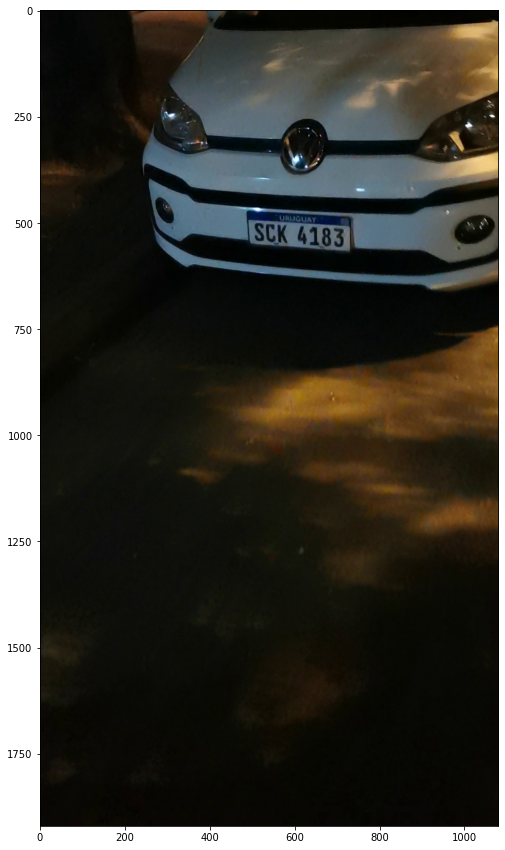

In [5]:
#cargo una imagen del repositorio
image = cv2.imread("plate_ocr_test/7.jpg")

#Copio imagen para no destruirla
image = np.copy(image)

#La leo en RGB
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

**3. Pre-processing**

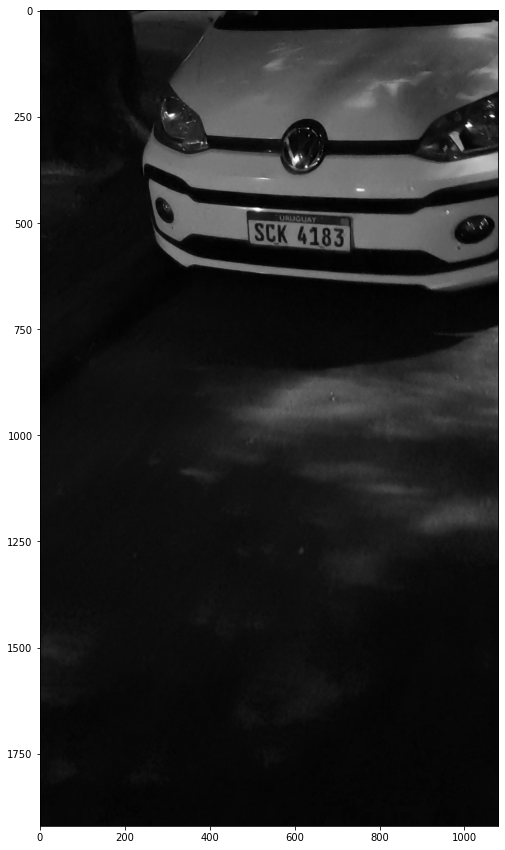

In [6]:
# la paso a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

**4. Seleccionar áreas de interes**

4.1 Aplico una operación morfológica Blackhat de OpenCV, con kernel las dimensiones aproximadas de una matricula en pixeles

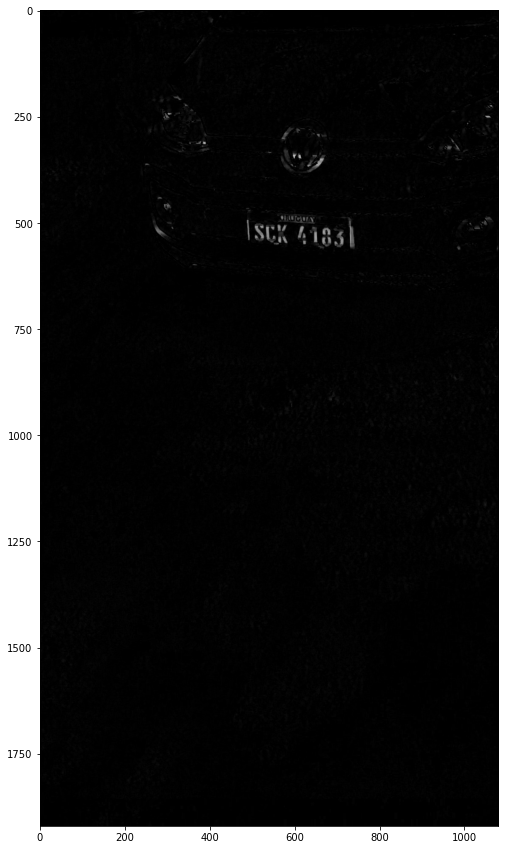

In [7]:
rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (widePlatePx, tallPlatePx))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)

plt.imshow(blackhat, cmap='gray')

4.2 Filtro Sobel en la dirección de las x para la detección de bordes y normalización a 0,255

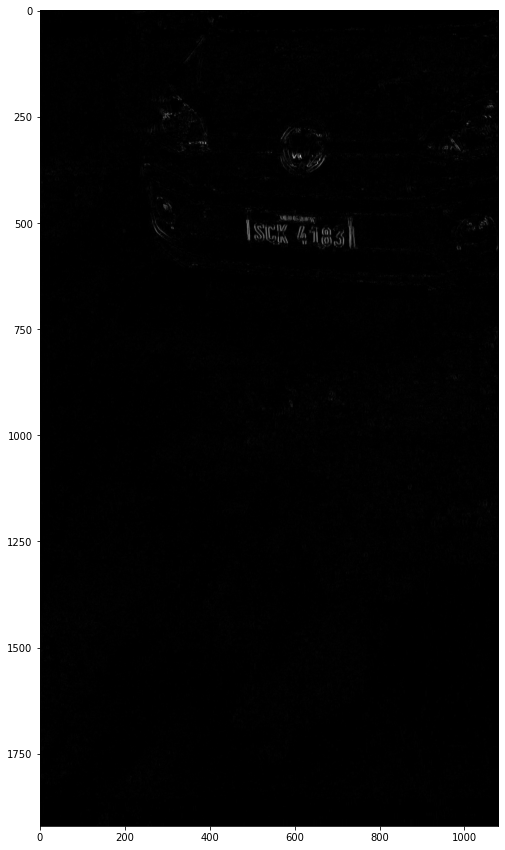

In [8]:
sobelX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
sobelX = np.absolute(sobelX)
(minVal, maxVal) = (np.min(sobelX), np.max(sobelX))
sobelX = 255 * ((sobelX - minVal) / (maxVal - minVal))
sobelX = sobelX.astype("uint8")

plt.imshow(sobelX, cmap='gray')

4.3 Aplicación de filtros para detectar zona de la matricula

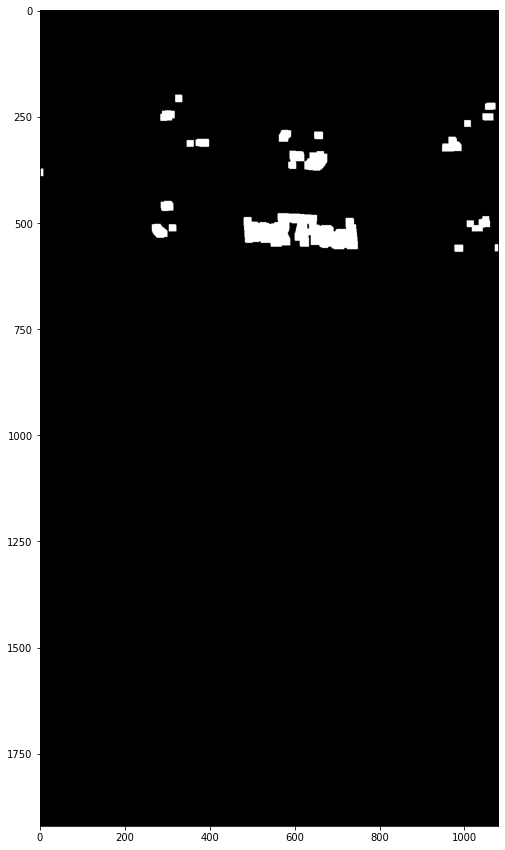

In [9]:
# Gaussian blur + closing + método de Otsu
sobelX = cv2.GaussianBlur(sobelX, (3, 3), 0)
sobelX = cv2.morphologyEx(sobelX, cv2.MORPH_CLOSE, rectKern)
thresh = cv2.threshold(sobelX, 0, 255,	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# aplico erosión y dilatación para eliminar ruido
thresh = cv2.erode(thresh, None, iterations=1)
thresh = cv2.dilate(thresh, None, iterations=8)
thresh = cv2.erode(thresh, None, iterations=1)

plt.imshow(thresh, cmap='gray')

**4.4 Máscara de zonas claras**

Por otro lado, voy a buscar las zonas claras de la foto, para hacerle un and bit a bit a la imagen encontrada anteriormente

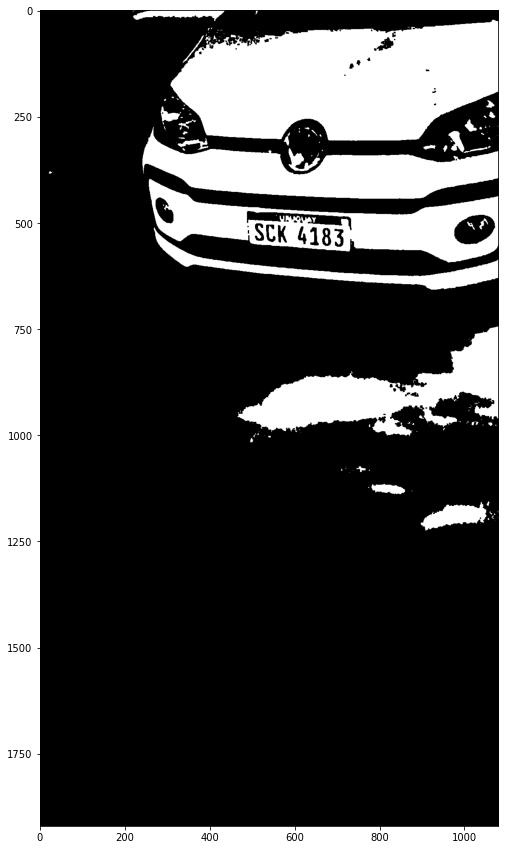

In [10]:
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(light, cmap='gray')


Ahora le aplico la máscara a la imagen anterior

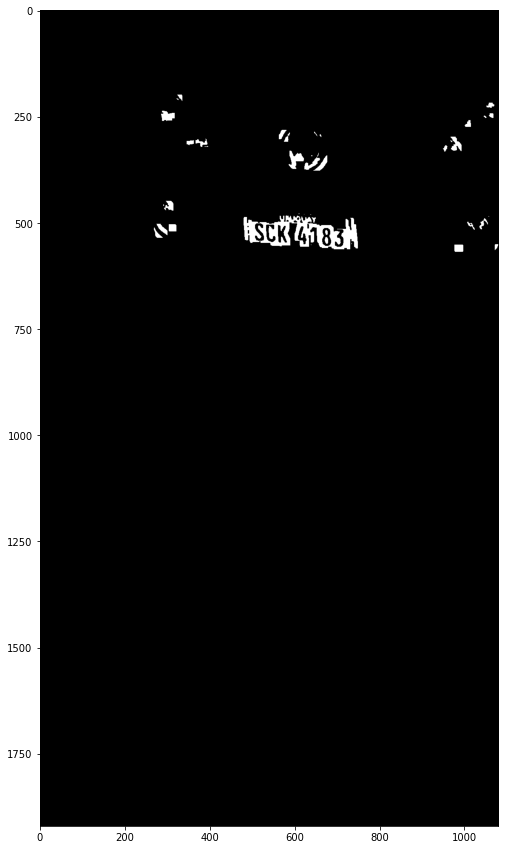

In [11]:
# Aplicar la máscara para reslatar zonas que pueda estar la matrícula
thresh = cv2.bitwise_and(thresh, thresh, mask=light)
plt.imshow(thresh, cmap='gray')

Le aplico closing principalmente por si el vehiculo es blanco y la máscara no funcionó correctamente

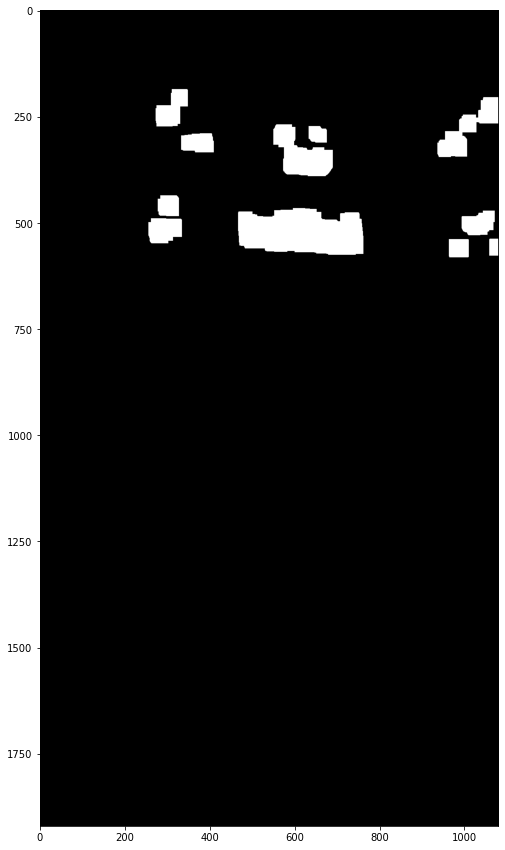

In [12]:
thresh = cv2.dilate(thresh, None, iterations=5)
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=10)
thresh = cv2.erode(thresh, None, iterations=3)
thresh = cv2.dilate(thresh, None, iterations=5)
thresh = cv2.erode(thresh, None, iterations=2)

plt.imshow(thresh, cmap='gray')

**4.5 Detectar contornos**


In [13]:
# detecto contornos y me queddo con los keep mas grandes
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]

**4.6 Localizar matricula**

Se recorren los contornos para ver cual cumple con las condiciones de matricula

Se utilizan 3 variables para almacenar la posible matricula:
lpCont : license plate contour almacenará el Contour de la matrícula
roi : region of interest es la imagen con la matrícula extraida para procesar
licensePlate: es la foto recortada de la zona considerada matrícula

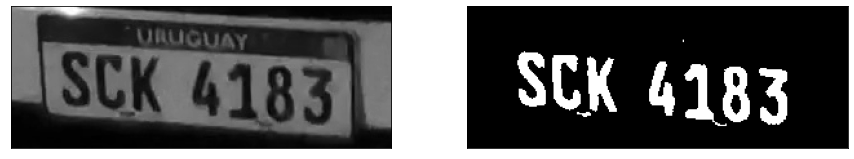

In [14]:
# inicializo el Contour de la matrícula y la region de interes que será la imagen a procesar
lpCnt = None
roi = None
# busco el Contour que cumpla las condiciones de matrícula
for c in cnts:
	  # calculo el ratio del rectángulo del Contour
	  (x, y, w, h) = cv2.boundingRect(c)
	  ar = w / float(h)

		# Verifico que el Contour cumpla las condiciones fijadas
	  if ar >= minAR and ar <= maxAR:
      # Almaceno las 3 variables si encontré el candidato
				lpCnt = c
				licensePlate = gray[y:y + h, x:x + w]
				roi = cv2.threshold(licensePlate, 0, 255,	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                  
      # Ejecuto la función clear_border de scikit-image
				roi = clear_border(roi)
    
      # Corto el loop cuando encuentro el mejor candidato 
				fig = plt.figure(figsize=(15,8))
				ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
				ax.imshow(np.squeeze(licensePlate), cmap='gray')
				ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
				ax.imshow(np.squeeze(roi), cmap='gray')
				break


**5. Predicción/Reconocimiento**

In [15]:
# Inicializo la variable que contedrá el texto
lpText = None


In [16]:
# Configuro Tesseract
alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
options = "-c tessedit_char_whitelist={}".format(alphanumeric)
# set the PSM mode
options += " --psm {}".format(psm)

In [17]:
# Valido que haya encontrado alguna zona para procesar
if roi is not None:
# Ejecuto el OCR de la imagen encontrada
		lpText = pytesseract.image_to_string(roi, config=options)
		print(lpText)

SCK 4183



**6. Acción**

Se agrega la cajita con la matricula en la foto original

[INFO] SCK 4183



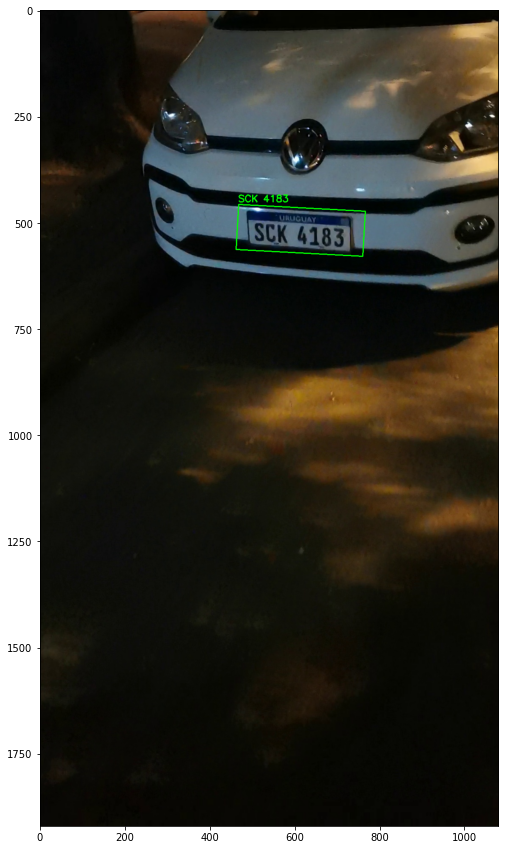

In [18]:
def cleanup_text(text):
	# Para solo imprimir caracteres ASCII
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()
 
# Si detectó texto
if lpText is not None and lpCnt is not None:
		# Dibujo la caja del Contour identificado
		box = cv2.boxPoints(cv2.minAreaRect(lpCnt))
		box = box.astype("int")
		cv2.drawContours(image, [box], -1, (0, 255, 0), 2)
        
		# Coloco el texto en la imagen
		(x, y, w, h) = cv2.boundingRect(lpCnt)
		cv2.putText(image, cleanup_text(lpText), (x, y - 15),	cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        
		# Imprimo la imagen
		print("[INFO] {}".format(lpText))
		plt.imshow(image)